## Standard imports

In [1]:
#Importing Functions, Libraries and Viz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydataset
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.preprocessing

import warnings
warnings.filterwarnings("ignore")

from math import sqrt
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

# from linear_model: LinearRegression (OLS), LassoLars, TweedieRegressor (Generalized Linear Model)
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

import env
import os

import wrangle

## Zillow Regression Project

## Predicting Tax Assessed Value
<hr style="border-top: 50px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

### Project Goals
- The main goal of this project is to identify key drivers of Tax assessement for single family houses that were sold in 2017.

#### Project Description
- Create a model that best predicts home values in the housing market.
- Compare all models and evaluated by how well they performs over the baseline.


#### Initial Questions
1. Does the number of bedrooms & bathrooms in a house influence the price of the home?
2. Does size/area of the house influence the price of the home?
3. Does the age of the house influence the price of the home?
4. Does the location of the house influence the price of the home?


## I. Data Acquisition
<hr style="border-top: 50px groove green; margin-top: 1px; margin-bottom: 1px"></hr>
- I acquired my Zillow data using df wrangle.get_zillow_data()

In [2]:
#acquire data
df = wrangle.get_zillow_data()
df

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips
0,2.0,1.0,1174.0,155395.0,1937.0,6037.0
1,5.0,3.0,2299.0,283765.0,1977.0,6037.0
2,2.0,1.5,1008.0,332406.0,1964.0,6059.0
3,6.0,5.5,4041.0,1587088.0,2005.0,6059.0
4,2.0,2.0,1064.0,231539.0,1964.0,6059.0
...,...,...,...,...,...,...
52436,3.0,2.0,1060.0,535751.0,1954.0,6037.0
52437,3.0,3.0,1813.0,233667.0,1988.0,6037.0
52438,3.0,2.0,1820.0,599893.0,1962.0,6037.0
52439,3.0,2.0,2049.0,664000.0,2005.0,6111.0


## II. Data Cleaning & Preparation

### . I cleaned my data by getting rid of null values, outliers and renaming columns for easy readability.

In [3]:
#clean data with renamed columns for readability 
df = wrangle.clean_zillow_data()
df

,bedrooms,bathrooms,area,assessed_value,year_built,county
0,2.0,1.0,1174.0,155395.0,1937.0,Los_Angeles
1,5.0,3.0,2299.0,283765.0,1977.0,Los_Angeles
2,2.0,1.5,1008.0,332406.0,1964.0,Orange
4,2.0,2.0,1064.0,231539.0,1964.0,Orange
6,4.0,2.0,2058.0,1070530.0,1960.0,Orange
...,...,...,...,...,...,...
52436,3.0,2.0,1060.0,535751.0,1954.0,Los_Angeles
52437,3.0,3.0,1813.0,233667.0,1988.0,Los_Angeles
52438,3.0,2.0,1820.0,599893.0,1962.0,Los_Angeles
52439,3.0,2.0,2049.0,664000.0,2005.0,Ventura


### . After cleaning my dataframe I split data into train, validate and test datasets.
### . The data is now ready for exploration and modeling.

In [4]:
# this function is splitting data to train, validate, and test to avoid data leakage
def split_data(df):
    '''
    This function performs split on zillow data, stratify assesed value.
    Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(df, test_size=.2, random_state=123) 
                                            
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123) 
                                    
    return train, validate, test


In [5]:
#Split data
train_validate, test = train_test_split(df, train_size = 0.2, random_state=123)
train, validate = train_test_split(train_validate, train_size = 0.3, random_state=123)
train.shape, validate.shape, test.shape

((2827, 6), (6597, 6), (37697, 6))

In [6]:
#check train columns
train.head()

,bedrooms,bathrooms,area,assessed_value,year_built,county
45903,3.0,1.0,936.0,449000.0,1947.0,Los_Angeles
21951,3.0,1.0,1242.0,502233.0,1929.0,Los_Angeles
8637,3.0,1.5,1524.0,383119.0,1954.0,Orange
14763,3.0,3.0,1635.0,307538.0,1990.0,Orange
37559,4.0,2.0,1599.0,340693.0,1966.0,Orange


## III. Data Exploration
<hr style="border-top: 50px groove green; margin-top: 1px; margin-bottom: 1px"></hr>


### After data preparation, we now explore the data to identify the key drivers we need to estimate zillow property assessed value using train dataset.


### What is FIPS?
### FIPS is Federal Information Processing System codes that are used to uniquely identify geographic areas.
### I renamed my Fips column to county which has three counties: Los Angeles, Orange and Ventura

### Heatmap
### Which features have the highest correlations with assessed value?

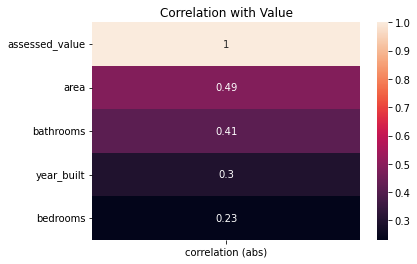

In [7]:
#visualize heatmap assessed value correlation to various features
corr = pd.DataFrame(train.corr().abs().assessed_value).sort_values(by='assessed_value', ascending=False)
corr.columns = ['correlation (abs)']
sns.heatmap(corr, annot=True)
plt.title('Correlation with Value')
plt.show()


### Exploration Summary
### - There is a high correlation between area, bathroom, year built, and assessed value.
### - The area/size of the house has the strongest correlation out of all the features.
### - I decided to use all these features for exploration & to fit into the model and evaluate their performance.

### 1. Bedrooms & bathrooms
### Does the number of bedrooms & bathrooms in a house influence the price of the home?

### Statistical Test

In [8]:
#alpha
a = 0.05

### H0 : There is no relationship between number of bedrooms & bathrooms to home prices
### Ha : There is a relationship between number of bedrooms & bathrooms to home prices

In [9]:
# this statistical test takes in the number of bedrooms/bathrooms to assessed value and 
# returns the correlation and p value to determine the statistical significance to alpha
x = train.bedrooms
y = train.assessed_value

corr, p = stats.pearsonr(x, y)
print(f'corr = {corr:.5f}')
print(f'p = {p:.5f}')

if p<a:
    print(f"reject the null hypothesis")
else:
    print(f"reject the null hypothesis")

corr = 0.23146
p = 0.00000
reject the null hypothesis


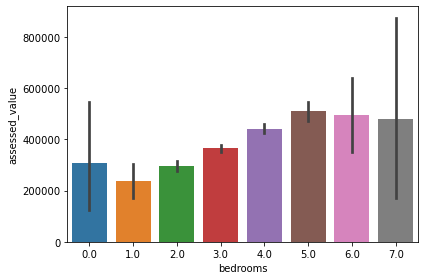

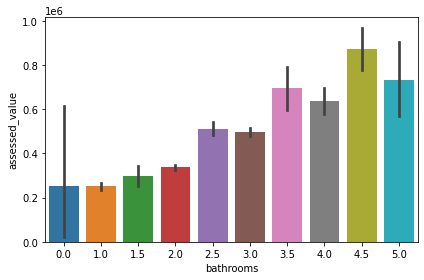

In [10]:
#make my target train assessed value and check relationship of bedrooms & bathrooms to price of home
target = train.assessed_value
train_drop = train.drop(columns=["area","assessed_value","year_built","county"])

# plot independent variables against dependent variables
for col in train_drop:
    sns.barplot(x=train_drop[col], y=target, data=train_drop)
    plt.ylabel('assessed_value')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

### takeaways:
### - We can see that there is a positive correlation between the number of bedrooms and bathrooms to the cost of the house
### - The more the number of bedrooms and bathrooms the higher the price of homes

### 2. Area
### Does size/area of the house influence the price of the home?

### Statistical Test

In [11]:
#alpha
a = 0.05

### H0 : There is no relationship between size of house to home prices
### Ha : There is a relationship between size of house to home prices

In [12]:
# this statistical test takes in the size of houses to assessed value and 
# returns the correlation and p value to determine the statistical significance to alpha
x= train["area"]
y = train["assessed_value"]
r1, p3 = stats.pearsonr(x, y)
print(f'r = {r1:.5f}')
print(f'p = {p3:.5f}')

if p<a:
    print(f"reject the null hypothesis")
else:
    print(f"reject the null hypothesis")

r = 0.48650
p = 0.00000
reject the null hypothesis


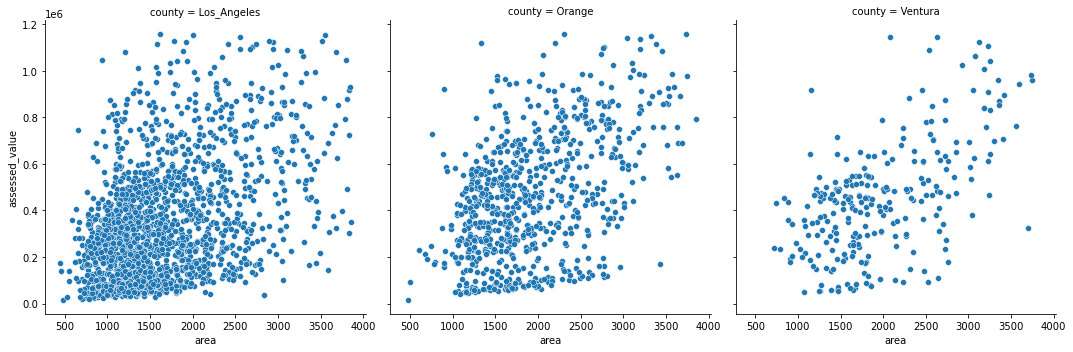

In [13]:
#relplot on three graphs to see the correlation between the size of the house and price in different counties
sns.relplot(x="area", y="assessed_value", data=train,  kind='scatter', height=5, col='county')
plt.show()

### takeaways:
### - We can see that the size of the house has a high positive correlation with price of houses in different counties.
### - Therefore the smaller the size of houses the higher the lower the home value.
### - There high correlation for smaller houses in Los Angeles county that in Orange & Ventura


### 3. Does the age of the house influence the price of the homes

### Statistical Test

In [14]:
#alpha
a = 0.05

### H0 : There is no relationship between age of house to home prices
### Ha : There is a relationship between age of house to home prices

In [15]:
# this statistical test takes in the age of houses to assessed value and 
# returns the correlation and p value to determine the statistical significance to alpha
x1= train["year_built"]
y1 = train["assessed_value"]
r1, p3 = stats.pearsonr(x1, y1)
print(f'r = {r1:.5f}')
print(f'p = {p3:.5f}')

if p<a:
    print(f"reject the null hypothesis")
else:
    print(f"reject the null hypothesis")

r = 0.29604
p = 0.00000
reject the null hypothesis


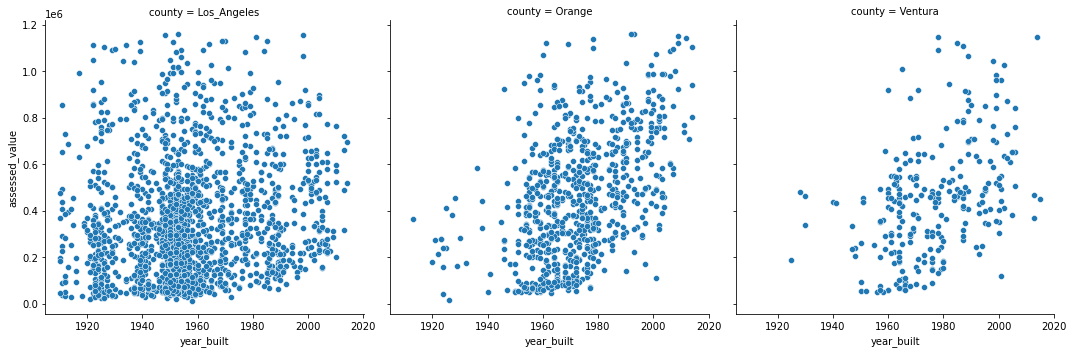

In [16]:
#relplot on three graphs to see the correlation between the age of the house and price in different counties
sns.relplot(x="year_built", y="assessed_value", data=train,  kind='scatter', height=5, col='county')
plt.show()

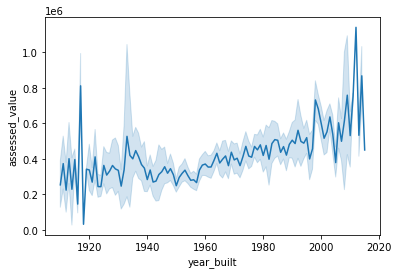

In [17]:
#lineplot showing correlation between assessed value over years
plt.figure()
sns.lineplot(train.year_built, train.assessed_value)
plt.xlabel='year_built'
plt.ylabel= 'assessed_value'

plt.show()

### takeaways
### - We can see that there is a high positive correlation on houses in Los Angeles county as they age compared to houses in Orange & Ventura counties.
### - On the other hand newer houses in Orange & Ventura counties are more expensive compared to Los Angeles county.


### 4.Does the location of the house influence the price of the home?

### Statistical Test

In [18]:
#alpha
a = 0.05

### H0 : There is no relationship between location of house to home prices
### Ha : There is a relationship between location of house to home prices

In [19]:
# this statistical test takes in the location of houses to assessed value and 
# returns the correlation and p value to determine the statistical significance to alpha
x2= train["county"].map({"Los_Angeles":0,"Orange":1,"Ventura":2})
y2 = train["assessed_value"]
r1, p3 = stats.pearsonr(x2, y2)
print(f'r = {r1:.5f}')
print(f'p = {p3:.5f}')

if p<a:
    print(f"reject the null hypothesis")
else:
    print(f"reject the null hypothesis")

r = 0.19941
p = 0.00000
reject the null hypothesis


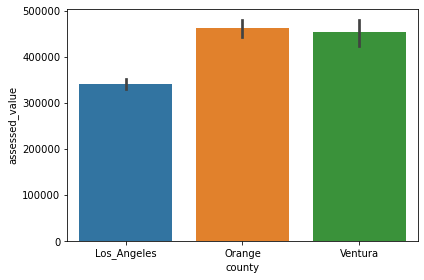

In [20]:
#barplot to check location of houses and assessed value
target = train.assessed_value
#train_drop = train.drop(columns=["area","assessed_value","year_built","county"])
train_drop = train.drop(columns=["bedrooms", "bathrooms", "area","year_built","assessed_value"])

# plot independent variables against dependent variables
for col in train_drop:
    sns.barplot(x=train_drop[col], y=target, data=train_drop)
    plt.tight_layout()
    plt.show()

### takeaway
### - We can see that houses in Orange & Ventura counties have a high tax value compared to houses in Los Angeles county.

<hr style="border-bottom: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>


## IV. Model Data & Evaluation
<hr style="border-top: 50px groove green; margin-top: 1px; margin-bottom: 1px"></hr>


### I used a function that scales the 3 data splits using MinMax Scaler. 
### Takes in train, validate, and test data splits as well as a list of the features to scale.
### I set my baseline and used 4 types of models to choose the best performing:
### - Linear Regression OLS
### - LassoLars w/ alpha = 1.0
### - Polynomial Regression


### The Test data was evaluated splitting it into X, y, and X_scaled datasets as well as isolating features, the target, and scaled data

In [21]:
#Write function to scale data for zillow data
def scale_data(train, validate, test, features_to_scale):
    """Scales the 3 data splits using MinMax Scaler. 
    Takes in train, validate, and test data splits as well as a list of the features to scale. 
    Returns dataframe with scaled counterparts on as columns"""
    
    
    # Make the thing to train data only
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(train[features_to_scale])
    
    # Fit the thing with new column names with _scaled added on
    scaled_columns = [col+"_scaled" for col in features_to_scale]
    
    # Transform the separate datasets using the scaler learned from train
    scaled_train = scaler.transform(train[features_to_scale])
    scaled_validate = scaler.transform(validate[features_to_scale])
    scaled_test = scaler.transform(test[features_to_scale])
    
    # Apply the scaled data to the original unscaled data
    train_scaled = pd.concat([train, pd.DataFrame(scaled_train,index=train.index, columns = scaled_columns)],axis=1)
    validate_scaled = pd.concat([validate, pd.DataFrame(scaled_validate,index=validate.index, columns = scaled_columns)],axis=1)
    test_scaled = pd.concat([test, pd.DataFrame(scaled_test,index=test.index, columns = scaled_columns)],axis=1)

    return train_scaled, validate_scaled, test_scaled

In [22]:
#scaled features
features_to_scale = ["bedrooms","bathrooms","area"]

In [23]:
#scaled features to train, validate & split
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, features_to_scale)

In [24]:
#split the dataset
X_train_scaled = train_scaled[["bedrooms_scaled","bathrooms_scaled","area_scaled"]]
y_train = train.assessed_value
X_validate_scaled = validate_scaled[["bedrooms_scaled","bathrooms_scaled","area_scaled"]]
y_validate = validate.assessed_value
X_test_scaled = test_scaled[["bedrooms_scaled","bathrooms_scaled","area_scaled"]]
y_test = test.assessed_value


In [25]:
#check X train scaled head
X_train_scaled.head(2)

,bedrooms_scaled,bathrooms_scaled,area_scaled
45903,0.428571,0.2,0.145157
21951,0.428571,0.2,0.234709


In [26]:
#add column names for scaling
columns = ["bedrooms","bathrooms","area"]

### Establish a Baseline
<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

In [27]:
#convert y_train, y_validate and y_test to dataframe
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [28]:
#calculate mean
baseline = df.assessed_value.mean()
baseline

382196.4075677511

In [29]:
#Create mean baseline model
y_train['baseline_mean_pred'] = y_train['assessed_value'].mean()
y_validate['baseline_mean_pred'] = y_validate['assessed_value'].mean()
#Create median baseline model
y_train['baseline_median_pred'] = y_train['assessed_value'].median()
y_validate['baseline_median_pred'] = y_validate['assessed_value'].median()
# we can now predict the mean for assessed value
assessed_value_mean = y_train.assessed_value.mean()
y_train['assessed_value_pred_mean'] = assessed_value_mean
y_validate['assessed_value_pred_mean'] = assessed_value_mean
# we can now predict the median for assessed value
assessed_value_median = y_train.assessed_value.median()
y_train['assessed_value_pred_median'] = assessed_value_median
y_validate['assessed_value_pred_median'] = assessed_value_median
y_test['assessed_value_pred_median'] = assessed_value_median
# Getting the RMSE assessed value_pred_mean
rmse_train = mean_squared_error(y_train.assessed_value, y_train.assessed_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.assessed_value, y_validate.assessed_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
# Getting the RMSE taxvalue_pred_median
rmse_train = mean_squared_error(y_train.assessed_value, y_train.assessed_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.assessed_value, y_validate.assessed_value_pred_median)**(1/2)

print("\nRMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Mean
Train/In-Sample:  256598.61 
Validate/Out-of-Sample:  252390.8

RMSE using Median
Train/In-Sample:  260787.23 
Validate/Out-of-Sample:  255637.63


In [30]:
# Takeaway
# From the above, we will use the mean since its the lowest

In [31]:
#RMSE for baseline into df
metric_df = pd.DataFrame(
data=[{
    'model': 'mean_baseline',
    'rmse_train': rmse_train, 
    'r^2_train':explained_variance_score(y_train.assessed_value,
                                           y_train.assessed_value_pred_mean)
}])

## Regression Models
<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

### 1. LinearRegression (Ordinary Least Squares-OLS)


In [32]:
# create model using OLS
lm = LinearRegression()
#fit the model
lm.fit(X_train_scaled, y_train.assessed_value)
# predict train
y_train['assessed_value_pred_lm'] = lm.predict(X_train_scaled)
# evaluate rmse
rmse_train = mean_squared_error(y_train.assessed_value, y_train.assessed_value_pred_lm)**(1/2)
# predict validate
y_validate['assessed_value_pred_lm'] = lm.predict(X_validate_scaled)
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_value, y_validate.assessed_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  222332.50306378497 
Validation/Out-of-Sample:  221199.34555789677


In [33]:
#get/append OLS RMSE into df
metric_df = metric_df.append(
{
    'model': 'OLS lm 1',
    'rmse_train': rmse_train, 
    'r^2_train':explained_variance_score(y_train.assessed_value,
                                           y_train.assessed_value_pred_lm)
}, ignore_index=True)

### 2. LassoLar

In [34]:
# create the model
lars = LassoLars(alpha=1.0)
# fit the model
lars.fit(X_train_scaled, y_train.assessed_value)
# predict train
y_train['assessed_value_pred_lars'] = lars.predict(X_train_scaled)
# evaluate: rmse
rmse_train = mean_squared_error(y_train.assessed_value, y_train.assessed_value_pred_lars)**(1/2)
# predict validate
y_validate['assessed_value_pred_lars'] = lars.predict(X_validate_scaled)
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_value, y_validate.assessed_value_pred_lars)**(1/2)

print("RMSE for LassoLars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for LassoLars
Training/In-Sample:  222332.54162863552 
Validation/Out-of-Sample:  221199.56947006122


In [35]:
#get/append LassoLars RMSE into df
metric_df = metric_df.append(
{
    'model': 'LassoLars alpha 1',
    'rmse_train': rmse_train, 
    'r^2_train':explained_variance_score(y_train.assessed_value,
                                           y_train.assessed_value_pred_lars)
}, ignore_index=True)

### 3. Polynomial Regression

In [36]:
from sklearn.preprocessing import PolynomialFeatures
# making the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)
# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

# create model using OLS
lm = LinearRegression()
#fit the model
lm.fit(X_train_degree2, y_train.assessed_value)
# predict train
y_train['assessed_value_pred_pf'] = lm.predict(X_train_degree2)
# evaluate rmse
rmse_train = mean_squared_error(y_train.assessed_value, y_train.assessed_value_pred_pf)**(1/2)
# predict validate
y_validate['assessed_value_pred_pf'] = lm.predict(X_validate_degree2)
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_value, y_validate.assessed_value_pred_pf)**(1/2)

print("RMSE for PF using Polynomial Regression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for PF using Polynomial Regression
Training/In-Sample:  222165.48668502603 
Validation/Out-of-Sample:  221143.45089921783


In [37]:
#get/append Polynomial RMSE into df 
metric_df = metric_df.append(
    {
    'model': 'Polynomial Model',
    'rmse_train': rmse_train,
    'r^2_train': explained_variance_score(y_train.assessed_value, y_train.assessed_value_pred_pf)}, ignore_index=True)
metric_df

,model,rmse_train,r^2_train
0,mean_baseline,260787.231323,0.000000
1,OLS lm 1,222332.503064,0.249247
2,LassoLars alpha 1,222332.541629,0.249246
3,Polynomial Model,222165.486685,0.250374


In [38]:
#takeaways
# Of the Three Regression models
# Polynomial seems to be the best model
# Apparently OLS & LassoLars have the same RMSE

### Evaluate
### Plotting Actual vs. Predicted Values

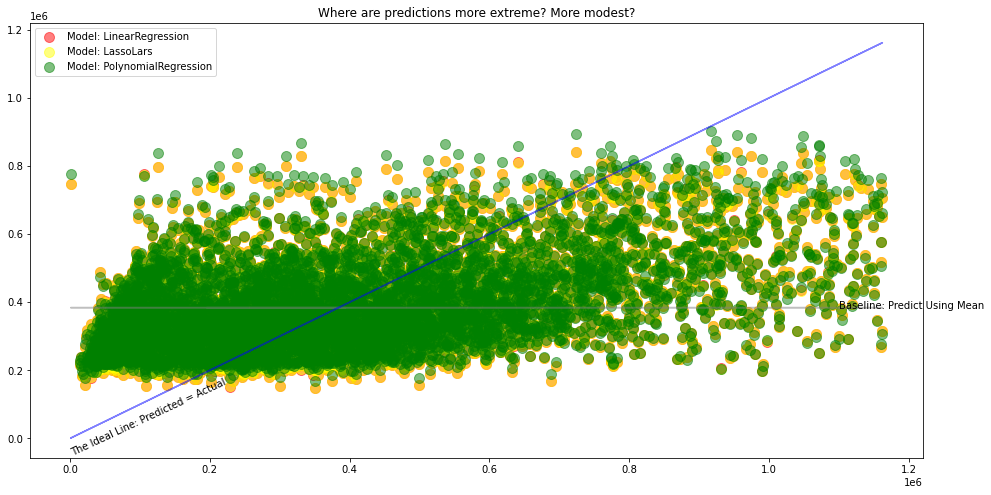

In [57]:
# plot actual vs predicted values
plt.figure(figsize=(16,8))
plt.plot(y_validate.assessed_value, y_validate.assessed_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (1_100_000, 380_000))
plt.plot(y_validate.assessed_value, y_validate.assessed_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, -50_000), rotation=25)

plt.scatter(y_validate.assessed_value, y_validate.assessed_value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.assessed_value, y_validate.assessed_value_pred_lars, 
            alpha=.5, color="yellow", s=100, label="Model: LassoLars")
plt.scatter(y_validate.assessed_value, y_validate.assessed_value_pred_pf, 
            alpha=.5, color="green", s=100, label="Model: PolynomialRegression")
plt.legend()
#plt.xlabel("Actual Vssessed Value")
#plt.ylabel("Predicted Assessed Value")
plt.title("Where are predictions more extreme? More modest?")
plt.show()

In [ ]:
#takeaways:
# predictions are extreme to the left of the graph and modest to the right of the graph.
# the lower the assessed values the higher the predictions.
# the higher the assessed values the lower the predictions.
# Polynomial was my best model, so I will utilize this to evaluate results on my test set as below
# NOTE: commented out y&x labels, it won't run on my final report but does on my workbook

### Test the Model
### Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
# making the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)
# transform X_validate_scaled & X_test_scaled
#X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

# create model using OLS
lm = LinearRegression()
#fit the model
lm.fit(X_train_degree2, y_train.assessed_value)
# predict train
y_train['assessed_value_pred_pf'] = lm.predict(X_train_degree2)
# evaluate rmse
rmse_train = mean_squared_error(y_train.assessed_value, y_train.assessed_value_pred_pf)**(1/2)
# predict validate
y_test['assessed_value_pred_pf'] = lm.predict(X_test_degree2)
# evaluate: rmse
rmse_test = mean_squared_error(y_test.assessed_value, y_test.assessed_value_pred_pf)**(1/2)

print("RMSE for PF using Polynomial Regression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_test)

In [ ]:
# The test on the Polynomial Model is similar to validate 

## V. Conclusions
<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>



## Summary

### In conclusion, all the features I used in my exploration successfully predicted home values were important especially size of homes. The number of bedrooms was surprisingly not as important as expected.
### All the models that I used performed better than the baseline.
### Of the top three models, Polynomial model is the best.

## Recommendations

### I recommend that Zillow should use Polynomial Regression model to predict tax assessement value
### Test data predicted an RMSE of 222,165.50 which is 38,622.50 more accurate than the baseline

## Next Steps

### Given more time I would include more columns on my dataset, improve my feature engineering, and increase model performance